# Requried Libraries

In [1]:
pip install pandas numpy scikit-learn pgmpy matplotlib seaborn 

Note: you may need to restart the kernel to use updated packages.


# Download the Dataset

In [3]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv(r"C:\Users\Shalabh Ranjan\Downloads\heart_disease.csv")

# Initial exploration
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Missing values:\n{df.isnull().sum()}")
print(f"Data types:\n{df.dtypes}")

Dataset shape: (303, 14)
Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
Missing values:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64
Data types:
age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


# Data Cleaning and Preprocessing

In [4]:
# Check for duplicates
print(f"Duplicates found: {df.duplicated().sum()}")
df_clean = df.drop_duplicates()

Duplicates found: 1


In [5]:
# Check missing values
missing_cols = df_clean.columns[df_clean.isnull().any()].tolist()
print(f"Columns with missing values: {missing_cols}")

# Strategy: Drop rows with missing values or impute
# For this project, typically drop rows with missing values
df_clean = df_clean.dropna()

Columns with missing values: []


In [6]:
from sklearn.preprocessing import MinMaxScaler

# Identify numeric columns to normalize
numeric_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Apply min-max normalization
scaler = MinMaxScaler()
df_clean[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])

# Bayesian Network Structure Definition

In [8]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Define the network structure
model = DiscreteBayesianNetwork([
    ('age', 'fbs'),
    ('fbs', 'target'),
    ('age', 'chol'),
    ('chol', 'target'),
    ('thalach', 'target')
])

# Model Training

In [9]:
# Discretize normalized continuous variables into bins
df_discrete = df_clean.copy()

# Create age groups
df_discrete['age'] = pd.cut(df_clean['age'], bins=3, labels=['young', 'middle', 'old'])

# Create cholesterol groups
df_discrete['chol'] = pd.cut(df_clean['chol'], bins=3, labels=['low', 'normal', 'high'])

# Create thalach groups
df_discrete['thalach'] = pd.cut(df_clean['thalach'], bins=3, labels=['low', 'normal', 'high'])

In [10]:
# Fit the model using Maximum Likelihood Estimation
model.fit(df_discrete[['age', 'fbs', 'chol', 'thalach', 'target']], 
          estimator=MaximumLikelihoodEstimator)

print("Model training completed!")
print(f"Nodes: {model.nodes()}")
print(f"Edges: {model.edges()}")

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'age': 'O', 'fbs': 'N', 'chol': 'O', 'thalach': 'O', 'target': 'N'}


Model training completed!
Nodes: ['age', 'fbs', 'target', 'chol', 'thalach']
Edges: [('age', 'fbs'), ('age', 'chol'), ('fbs', 'target'), ('chol', 'target'), ('thalach', 'target')]


# Model Inference

In [11]:
# Create inference object
inference = VariableElimination(model)

# Example queries
# 1. Probability of heart disease given normalized age
query1 = inference.query(variables=['target'], 
                        evidence={'age': 'middle'})
print("P(Heart Disease | Middle Age):")
print(query1)

# 2. Probability of heart disease given cholesterol distribution
query2 = inference.query(variables=['target'], 
                        evidence={'chol': 'high'})
print("P(Heart Disease | High Cholesterol):")
print(query2)

P(Heart Disease | Middle Age):
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.4587 |
+-----------+---------------+
| target(1) |        0.5413 |
+-----------+---------------+
P(Heart Disease | High Cholesterol):
+-----------+---------------+
| target    |   phi(target) |
+===========+===============+
| target(0) |        0.3322 |
+-----------+---------------+
| target(1) |        0.6678 |
+-----------+---------------+


# Visualization

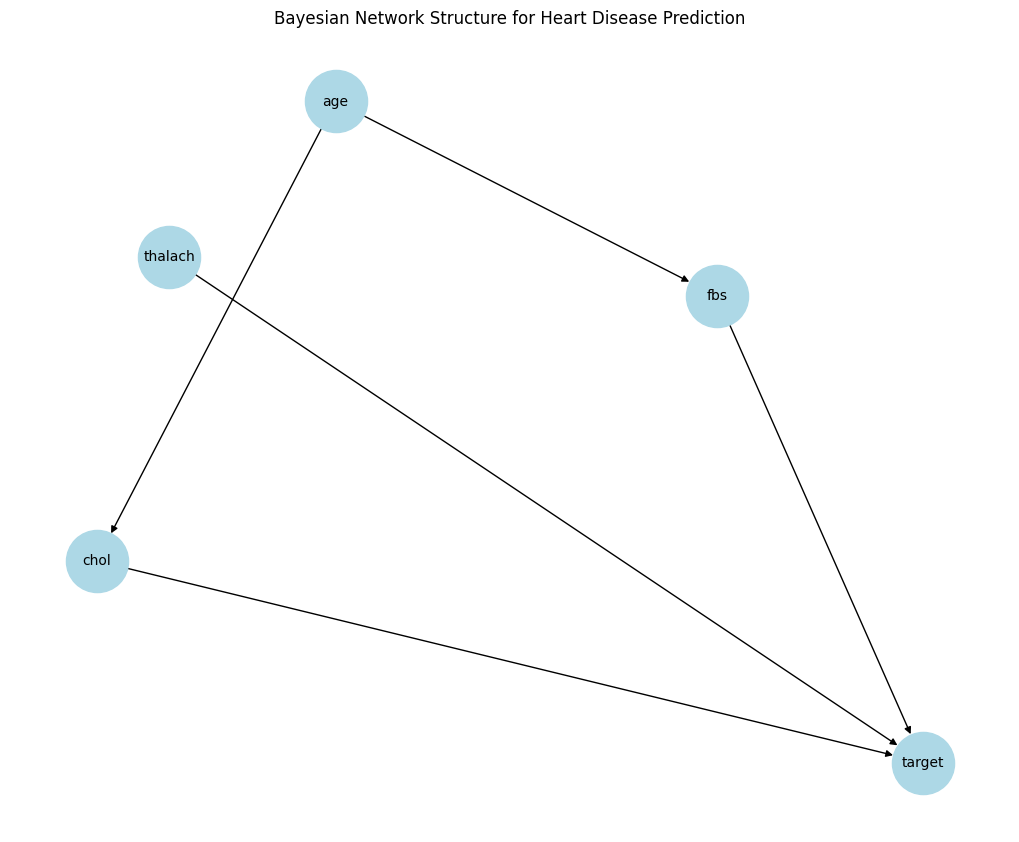

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

# Create network graph
G = nx.DiGraph()
G.add_edges_from(model.edges())

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=2000, font_size=10, arrows=True)
plt.title("Bayesian Network Structure for Heart Disease Prediction")
plt.show()

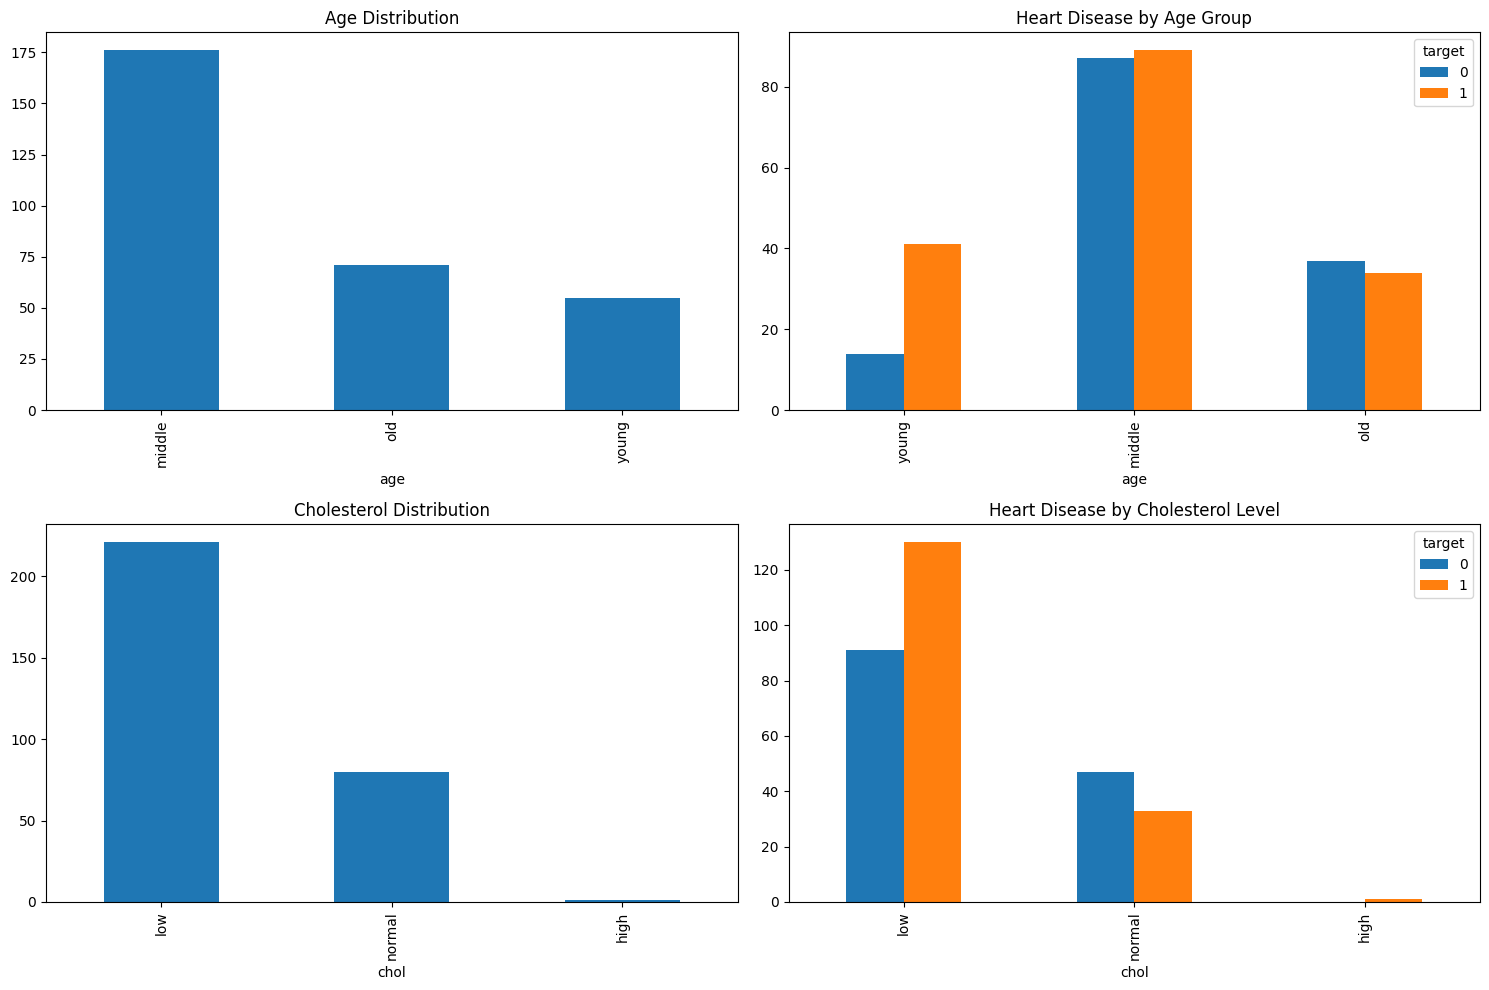

In [14]:
import seaborn as sns

# Visualize conditional probability tables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Age distribution
df_discrete['age'].value_counts().plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Age Distribution')

# Heart disease by age
pd.crosstab(df_discrete['age'], df_discrete['target']).plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Heart Disease by Age Group')

# Cholesterol distribution
df_discrete['chol'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Cholesterol Distribution')

# Heart disease by cholesterol
pd.crosstab(df_discrete['chol'], df_discrete['target']).plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Heart Disease by Cholesterol Level')

plt.tight_layout()
plt.show()

# Key Diagnostic Questions

In [15]:
def predict_heart_disease_probability(age_group=None, chol_level=None, fbs_status=None, thalach_level=None):
    """
    Predict probability of heart disease given various conditions
    """
    evidence = {}
    if age_group:
        evidence['age'] = age_group
    if chol_level:
        evidence['chol'] = chol_level
    if fbs_status is not None:
        evidence['fbs'] = fbs_status
    if thalach_level:
        evidence['thalach'] = thalach_level
    
    if evidence:
        query = inference.query(variables=['target'], evidence=evidence)
        return query.values[1]  # Probability of heart disease (target=1)
    else:
        return "No evidence provided"

# Example usage
prob1 = predict_heart_disease_probability(age_group='old', chol_level='high')
print(f"Probability of heart disease for old age + high cholesterol: {prob1:.3f}")

prob2 = predict_heart_disease_probability(age_group='young', chol_level='low')
print(f"Probability of heart disease for young age + low cholesterol: {prob2:.3f}")

Probability of heart disease for old age + high cholesterol: 0.668
Probability of heart disease for young age + low cholesterol: 0.582


# Model Evaluation

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare data for evaluation
X = df_discrete[['age', 'fbs', 'chol', 'thalach']]
y = df_discrete['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions on test set
predictions = []
for idx, row in X_test.iterrows():
    evidence = row.to_dict()
    query = inference.query(variables=['target'], evidence=evidence)
    pred = 1 if query.values[1] > 0.5 else 0
    predictions.append(pred)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {accuracy:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Model Accuracy: 0.738

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.86      0.76        29
           1       0.83      0.62      0.71        32

    accuracy                           0.74        61
   macro avg       0.75      0.74      0.74        61
weighted avg       0.76      0.74      0.73        61

